In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys
path = str(Path(Path('File.py').parent.absolute()).parent.absolute())
sys.path.insert(0, path)

import numpy as np
import matplotlib as mlab
import matplotlib.pyplot as plt
import xarray as xr
import os as os
import glob
import matplotlib.gridspec as gridspec
from collections import namedtuple
import tools

from tools.FV3_tools import read_solo_fields
from tools.WRF_tools import read_wrf_fields
from tools.CM1_tools import read_cm1_fields

import pickle
from tools.cbook import pickle2Obj

_nthreads = 2

models = {}

def check_data(models):
    for mkey in models.keys():
        for rkey in models[mkey]:
            print(mkey, rkey)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
models['cm1'] = pickle2Obj('precip/cm1_squall_3km_dt10_bench.pkl',retObj=False)
models['solo'] = pickle2Obj('precip/solo_squall_3km_n3_bench.pkl',retObj=False)
models['solo_hdd02'] = pickle2Obj('precip/solo_squall_3km_hdd02_bench.pkl',retObj=False)
models['wrf'] = pickle2Obj('precip/wrf_squall_3km_dt10_bench.pkl',retObj=False)

In [6]:
#models['wrf'] = pickle2Obj('precip/wrf_squall_3km_accum_prec.pkl', retObj=False)

In [7]:
#models['mpas'] = pickle2Obj('precip/mpas_squall_3km_3rd_bench.pkl',retObj=False)

In [3]:
check_data(models)

cm1 C2000_06
cm1 C3500_06
cm1 C2000_18
cm1 C3500_18
solo C2000_06
solo C3500_06
solo C2000_18
solo C3500_18
solo_hdd02 C2000_06
solo_hdd02 C3500_06
solo_hdd02 C2000_18
solo_hdd02 C3500_18
wrf C2000_06
wrf C3500_06
wrf C2000_18
wrf C3500_18


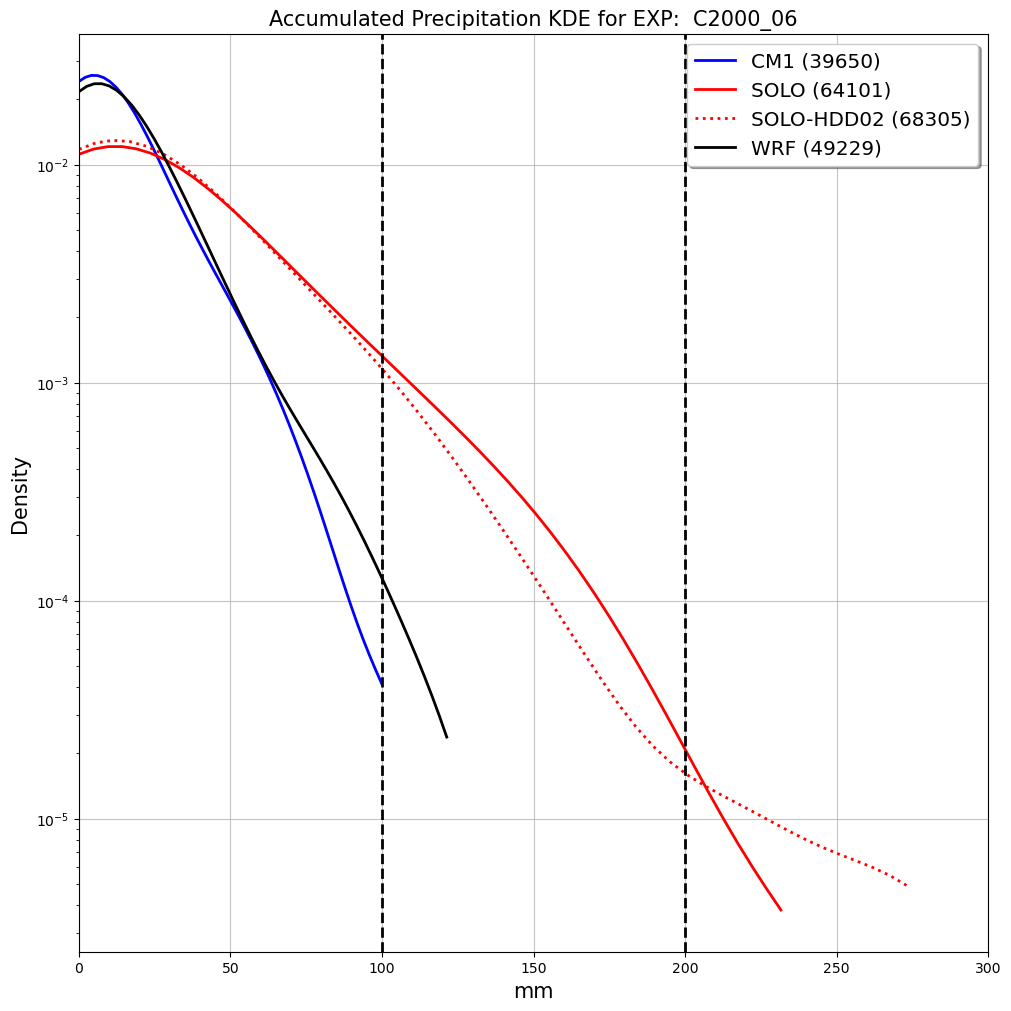

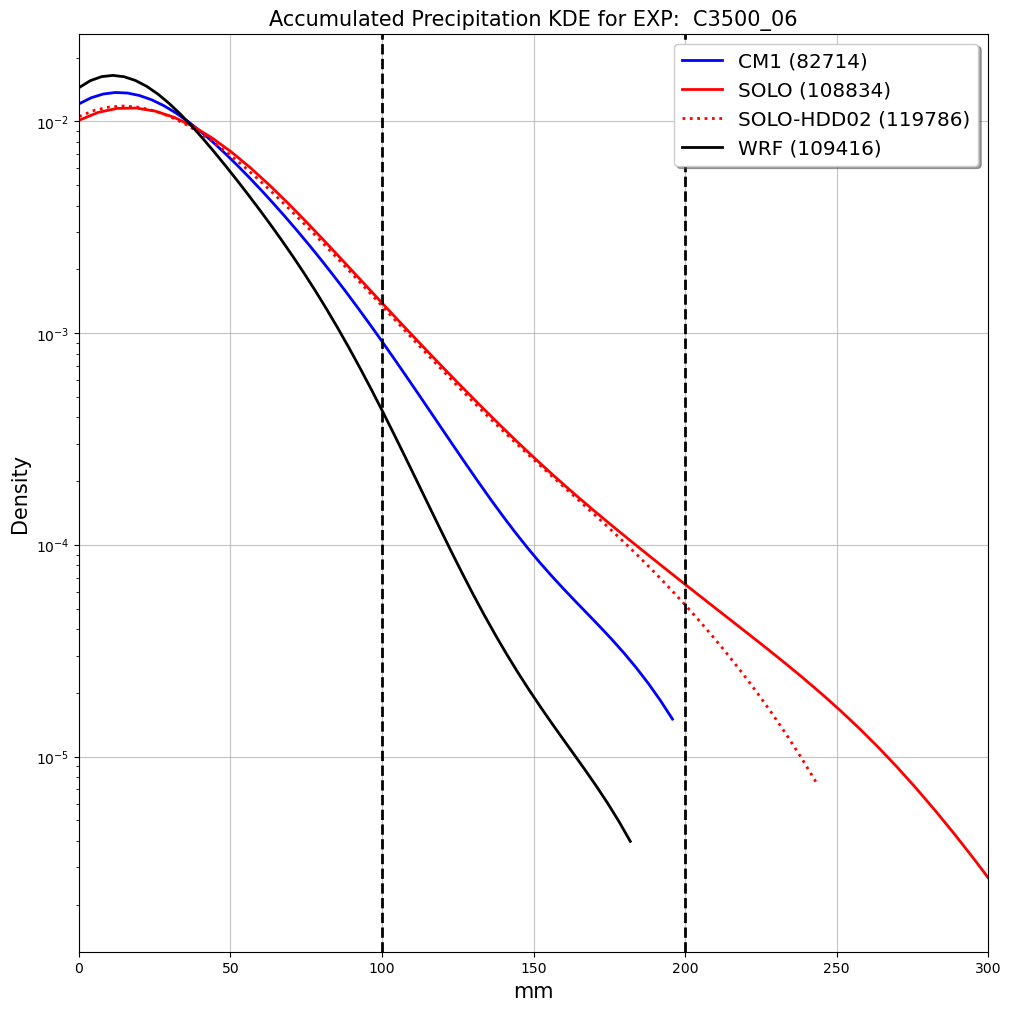

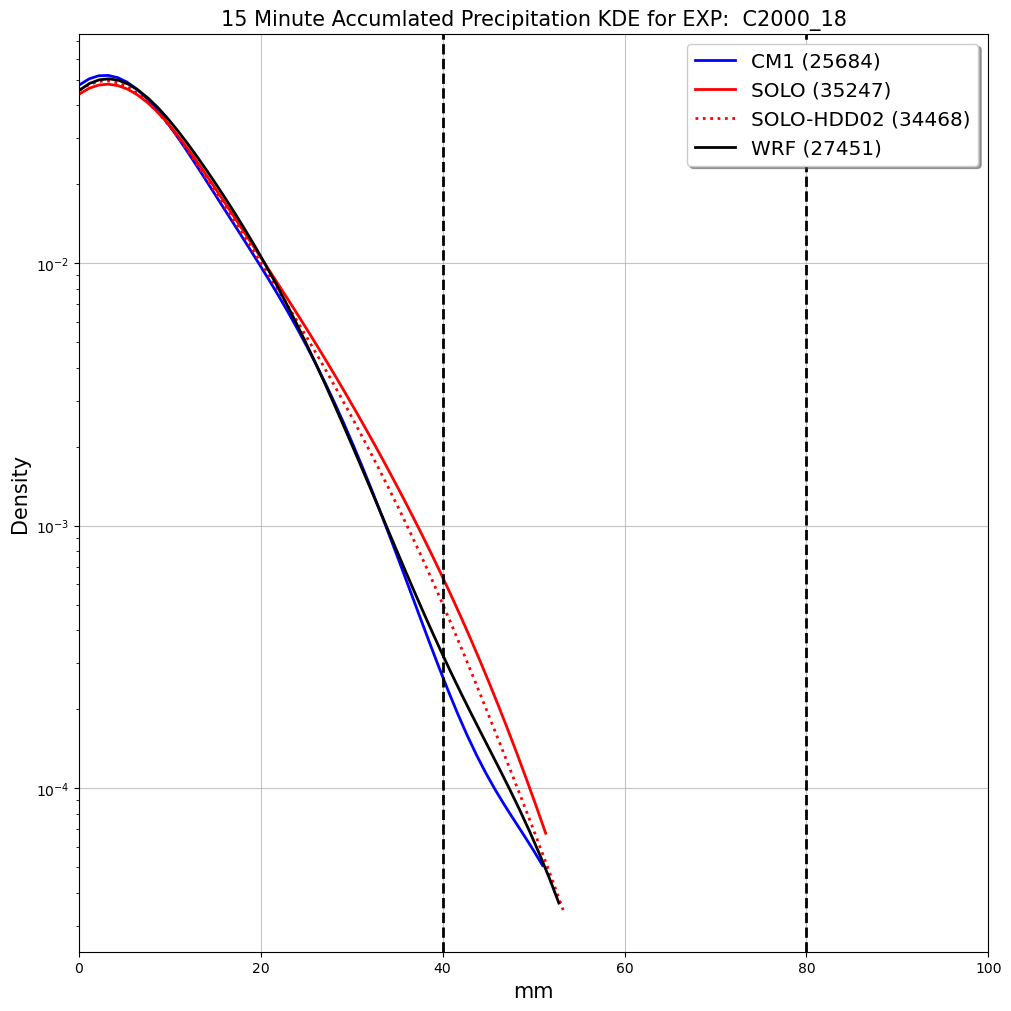

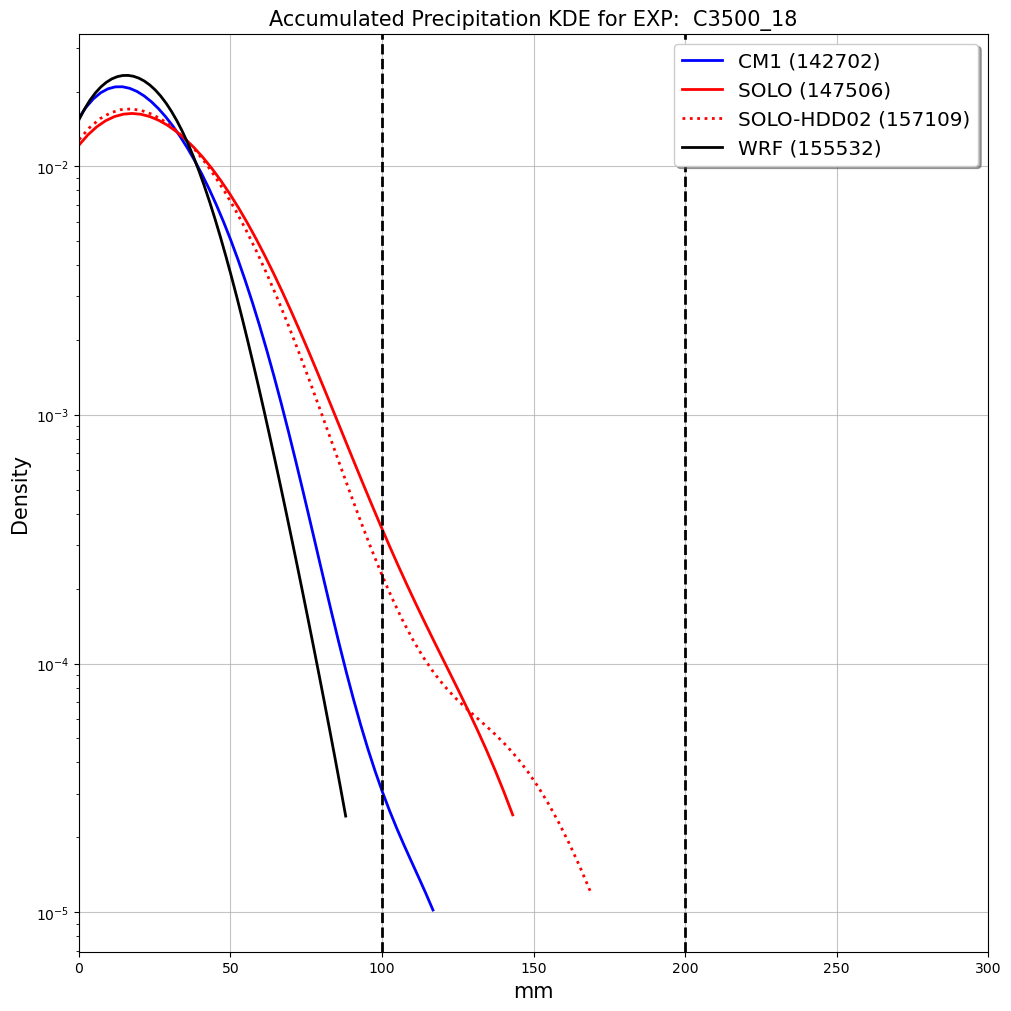

In [5]:
from scipy.stats import gaussian_kde

def precip_histogram(models, label, all_times=False):
    
    fig, ax = plt.subplots(1,1, constrained_layout=True,figsize=(10,10))
    
    if all_times:
        xlim = [0.0, 300.]
            
    else:
        xlim = [0.0, 100.]
    
    for key in models.keys():
        
        if all_times:
            
            precip_dt = models[key][label]['accum_prec']
            
        else:
    
        # first, compute the increments in time of precip
    
            inv = models[key][label]['accum_prec'][::-1]
    
            precip_dt = inv[0:-1] - inv[1:]
        
        # get rid of zeros...
    
        data_flat =precip_dt.flatten()
        
        data_no_zero = data_flat[data_flat >= 1.0e-1]
        
        hist, bin_edges = np.histogram(data_no_zero)

        eval_points = np.linspace(np.min(bin_edges), np.max(bin_edges))
        kde_sp      = gaussian_kde(data_no_zero, bw_method=0.9)
        y_sp        = kde_sp.pdf(eval_points)
        
        if key == 'solo':
            ax.plot(eval_points, y_sp, color='r', linewidth=2.0, label='SOLO (%d)' % data_no_zero.shape)
            
        if key == 'solo_hdd02':
            ax.plot(eval_points, y_sp, color='r', linewidth=2.0, linestyle=':', label='SOLO-HDD02 (%d)' % data_no_zero.shape)

        if key == 'wrf':
            ax.plot(eval_points, y_sp, color='k', linewidth=2.0, label='WRF (%d)' % data_no_zero.shape)
            
        if key == 'cm1':
            ax.plot(eval_points, y_sp, color='b', linewidth=2.0, label='CM1 (%d)' % data_no_zero.shape)
            
        if key == 'mpas':
            ax.plot(eval_points, y_sp, color='g', linewidth=2.0, label='MPAS (%d)' % data_no_zero.shape)
    
    ax.set_xlim(xlim[:])
    ax.set_yscale("log")
    plt.grid(axis='y', alpha=0.75)
    plt.grid(axis='x', alpha=0.75)
    ax.set_xlabel('mm',fontsize=15)
    ax.set_ylabel('Density',fontsize=15)
    legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
    if all_times:
        ax.axvline(x=100.0, color='k', linestyle='--', linewidth=2.0)
        ax.axvline(x=200.0, color='k', linestyle='--', linewidth=2.0)
        ax.set_title('Accumulated Precipitation KDE for EXP:  %s' % (label), fontsize=15)
        plt.savefig("Total_Accumlated_Precipitation_KDE_Experiment_%s.png" % (label))
    else:
        ax.axvline(x=40.0, color='k', linestyle='--', linewidth=2.0)
        ax.axvline(x=80.0, color='k', linestyle='--', linewidth=2.0)
        ax.set_title('15 Minute Accumlated Precipitation KDE for EXP:  %s' % (label), fontsize=15)
        plt.savefig("15_Minute_Accumlated_Precipitation_KDE_Experiment_%s.png" % (label))
    
    plt.show()
    
#precip_histogram(models, 'C1500_06')
#precip_histogram(models, 'C2000_06')
#precip_histogram(models, 'C3500_06')
precip_histogram(models, 'C2000_06', all_times = True)
precip_histogram(models, 'C3500_06', all_times = True)
# precip_histogram(models, 'C2500_06')
# precip_histogram(models, 'C3000_06')

#precip_histogram(models, 'C2000_12')
#precip_histogram(models, 'C2000_06', all_times = True)
#precip_histogram(models, 'C2000_18')
#precip_histogram(models, 'C2000_12')
precip_histogram(models, 'C2000_18')

#precip_histogram(models, 'C2000_12')

#precip_histogram(models, 'C3500_18')
#precip_histogram(models, 'C2000_12')
precip_histogram(models, 'C3500_18', all_times = True)

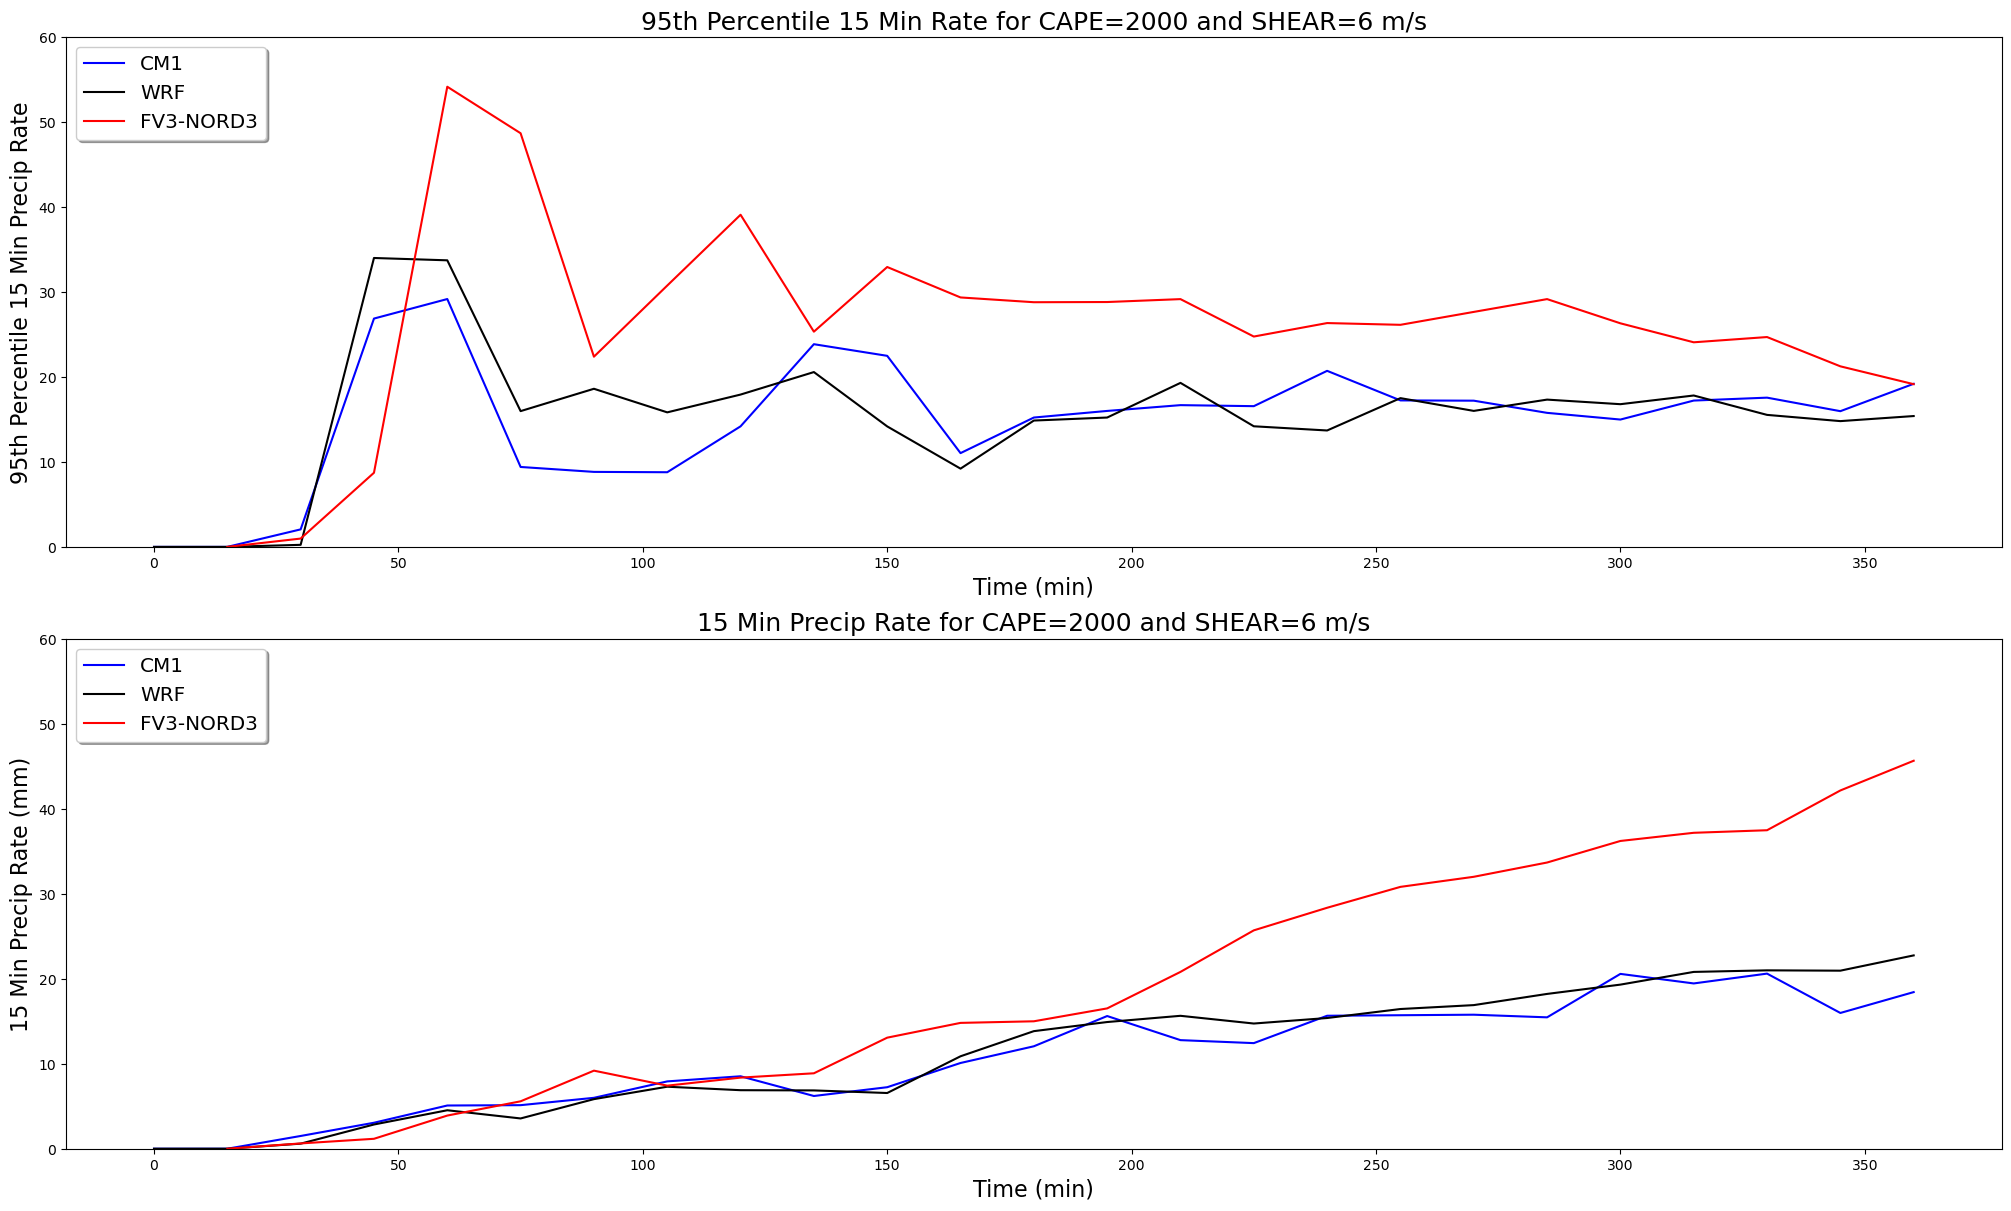

In [8]:
allcape = ("C2000",)
allshear = ("06",)

percent = 0.95

def plot_accum_prec(models, allcape, allshear, all_times=False):
    
    x = np.arange(5)

    if all_times:
        plim = [ [3.0e5, 5.0e5], [4.0e5, 6.5e5] ]
    else:
        plim = [ [60, 60], [60, 60] ]
        qlim = [ [60, 60], [60, 60] ]

    labels = []
    
    for cape in allcape:
        labels.append("%s" % (cape[1:]))
        
    for m, shear in enumerate(allshear):
        
        for n, cape in enumerate(allcape):
            
            label = "%s_%s" % (cape, shear)
            
            fig, ax = plt.subplots(2,1, constrained_layout=True,figsize=(20,12))

            for key in models.keys():
                
                if all_times:
                    precip = models[key][label]['accum_prec']
                else:
                    inv       = models[key][label]['accum_prec'][::-1]
                    ppp       = np.zeros_like(inv)
                    precip    = np.ma.zeros_like(inv)
                    ppp[1:,:] = (inv[0:-1] - inv[1:])[::-1]
                    precip    = np.ma.masked_greater(ppp, 1.0e-1)
                
                    precip_percent = np.zeros((ppp.shape[0],))
                    
                    for k in np.arange(ppp.shape[0]):
                        ptime   = ppp[k].reshape(precip.shape[1]*precip.shape[2])
                        pthresh = ptime[ptime > 1.0e-01]
                        
                        psort   = np.sort(pthresh)
                        idx     = np.int(percent * psort.shape[0])
                        if idx > 0:
                            precip_percent[k] = np.mean(psort[idx:])
                        else:
                            precip_percent[k] = 0.0
                                            
                if key == 'solo':
                    time = 15. + 15*np.arange(models[key][label]['accum_prec'].shape[0])
                    ax[1].plot(time, precip.sum(axis=(1,2)), color='r', linestyle='-', label='FV3-NORD3')
                    if not all_times:
                        ax[0].plot(time, precip_percent, color='r', linestyle='-', label='FV3-NORD3')
                    
                if key == 'solo2':
                    time = 15. + 15*np.arange(models[key][label]['accum_prec'].shape[0])
                    ax[1].plot(time, precip.sum(axis=(1,2)), color='r', linestyle='--', label='FV3-NORD2')
                    if not all_times:
                        ax[0].plot(time, precip_percent, color='r', linestyle='--', label='FV3-NORD2')
                    
                if key == 'solo1':
                    time = 15. + 15*np.arange(models[key][label]['accum_prec'].shape[0])
                    ax[1].plot(time, precip.sum(axis=(1,2)), color='r', linestyle=':', label='FV3-NORD1')
                    if not all_times:
                        ax[0].plot(time, precip_percent, color='r', linestyle=':', label='FV3-NORD1')

                if key == 'cm1':
                    time = 15*np.arange(models[key][label]['accum_prec'].shape[0])
                    ax[1].plot(time, precip.sum(axis=(1,2)), color='b', linestyle='-', label='CM1')
                    if not all_times:
                        ax[0].plot(time, precip_percent, color='b', linestyle='-', label='CM1')
            
                if key == 'wrf':
                    time = 15*np.arange(models[key][label]['accum_prec'].shape[0])
                    ax[1].plot(time, precip.sum(axis=(1,2)), color='k', linestyle='-', label='WRF')
                    if not all_times:
                        ax[0].plot(time, precip_percent, color='k', linestyle='-', label='WRF')
                        
                if key == 'mpas':
                    time = 15*np.arange(models[key][label]['accum_prec'].shape[0])
                    ax[1].plot(time, precip.sum(axis=(1,2)), color='g', linestyle='-', label='MPAS')
                    if not all_times:
                        ax[0].plot(time, precip_percent, color='g', linestyle='-', label='MPAS')
                        
            ax[0].set_ylabel('95th Percentile 15 Min Precip Rate', fontsize=16)
            ax[1].set_ylabel('15 Min Precip Rate (mm)', fontsize=16)
            ax[0].set_title('95th Percentile 15 Min Rate for CAPE=%d and SHEAR=%d m/s' % (int(cape[1:]), int(shear)), fontsize=18)
            ax[1].set_title('15 Min Precip Rate for CAPE=%d and SHEAR=%d m/s' % (int(cape[1:]), int(shear)), fontsize=18)
            ax[0].set_ylim(0, qlim[m][n])
            ax[1].set_ylim(0, plim[m][n])
            
            for k in [0,1]:
                ax[k].set_xlabel('Time (min)', fontsize=16)
                
                legend = ax[k].legend(loc='upper left', shadow=True, fontsize='x-large')
            
            plt.savefig("Precipitation_Time_Series_Experiment_%s.png" % (label))
            plt.show()
            
###############################

plot_accum_prec(models, allcape, allshear, all_times=False)

In [18]:
from scipy.stats import gaussian_kde

def precip_kde2(models, keys, labels, all_times=False):
    
    fig, ax = plt.subplots(1,1, constrained_layout=True,figsize=(10,10))
    
    if all_times:
        xlim = [0.0, 350.]
            
    else:
        xlim = [0.0, 100.]
    
    for key in keys:
        
        for label in labels:
        
            if all_times:

                precip_dt = models[key][label]['accum_prec']

            else:

            # first, compute the increments in time of precip

                inv = models[key][label]['accum_prec'][::-1]

                precip_dt = inv[0:-1] - inv[1:]

            # get rid of zeros...

            data_flat =precip_dt.flatten()

            data_no_zero = data_flat[data_flat >= 1.0e-1]

            hist, bin_edges = np.histogram(data_no_zero)

            eval_points = np.linspace(np.min(bin_edges), np.max(bin_edges))
            kde_sp      = gaussian_kde(data_no_zero, bw_method=0.5)
            y_sp        = kde_sp.pdf(eval_points)

            if label == 'C2000_06':
                ax.plot(eval_points, y_sp, color='r', linewidth=2.0, label='%s  %s' % (key, label))

            if label == 'C1500_06':
                ax.plot(eval_points, y_sp, color='r', linewidth=2.0, linestyle='--', label='%s  %s' % (key, label))

            if label == 'C2500_06':
                ax.plot(eval_points, y_sp, color='b', linewidth=2.0, linestyle='-', label='%s  %s' % (key, label))
                
            if label == 'C3000_06':
                ax.plot(eval_points, y_sp, color='b', linewidth=2.0, linestyle='--', label='%s  %s' % (key, label))

            if label == 'C3500_06':
                ax.plot(eval_points, y_sp, color='k', linewidth=2.0, label='%s  %s' % (key, label))

        ax.set_xlim(xlim[:])
        ax.set_yscale("log")
        ax.axvline(x=40.0, color='k', linestyle='--', linewidth=2.0)
        ax.axvline(x=80.0, color='k', linestyle='--', linewidth=2.0)
        plt.grid(axis='y', alpha=0.75)
        plt.grid(axis='x', alpha=0.75)
        ax.set_xlabel('mm',fontsize=15)
        ax.set_ylabel('Density',fontsize=15)
        legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
        if all_times:
            ax.set_title('Accumulated Precipitation KDE for EXP:  %s' % (label), fontsize=15)
            plt.savefig("Total_Accumlated_Precipitation_KDE_Experiment_%s.png" % (label))
        else:
            ax.set_title('15 Minute Accumlated Precipitation KDE for EXP:  %s' % (label), fontsize=15)
            plt.savefig("15_Minute_Accumlated_Precipitation_KDE_Experiment_%s.png" % (label))

        plt.show()



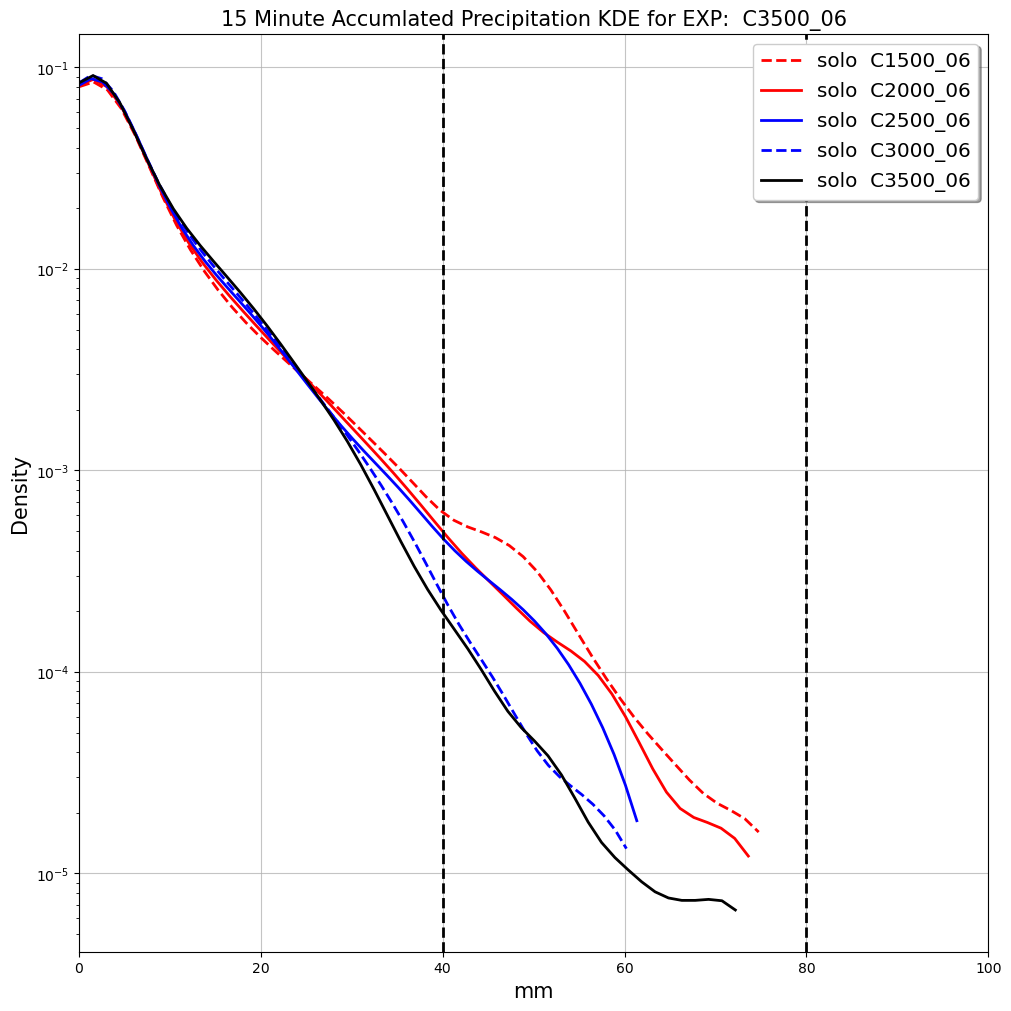

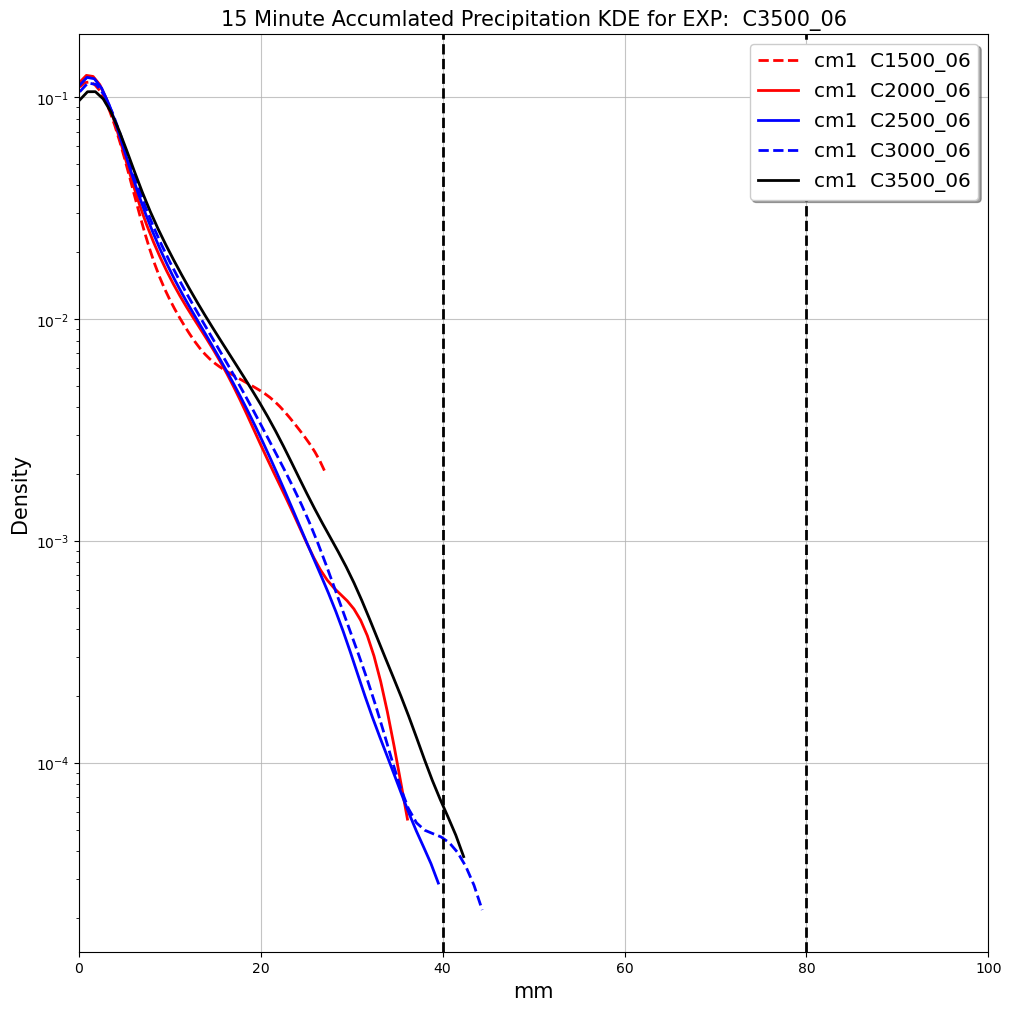

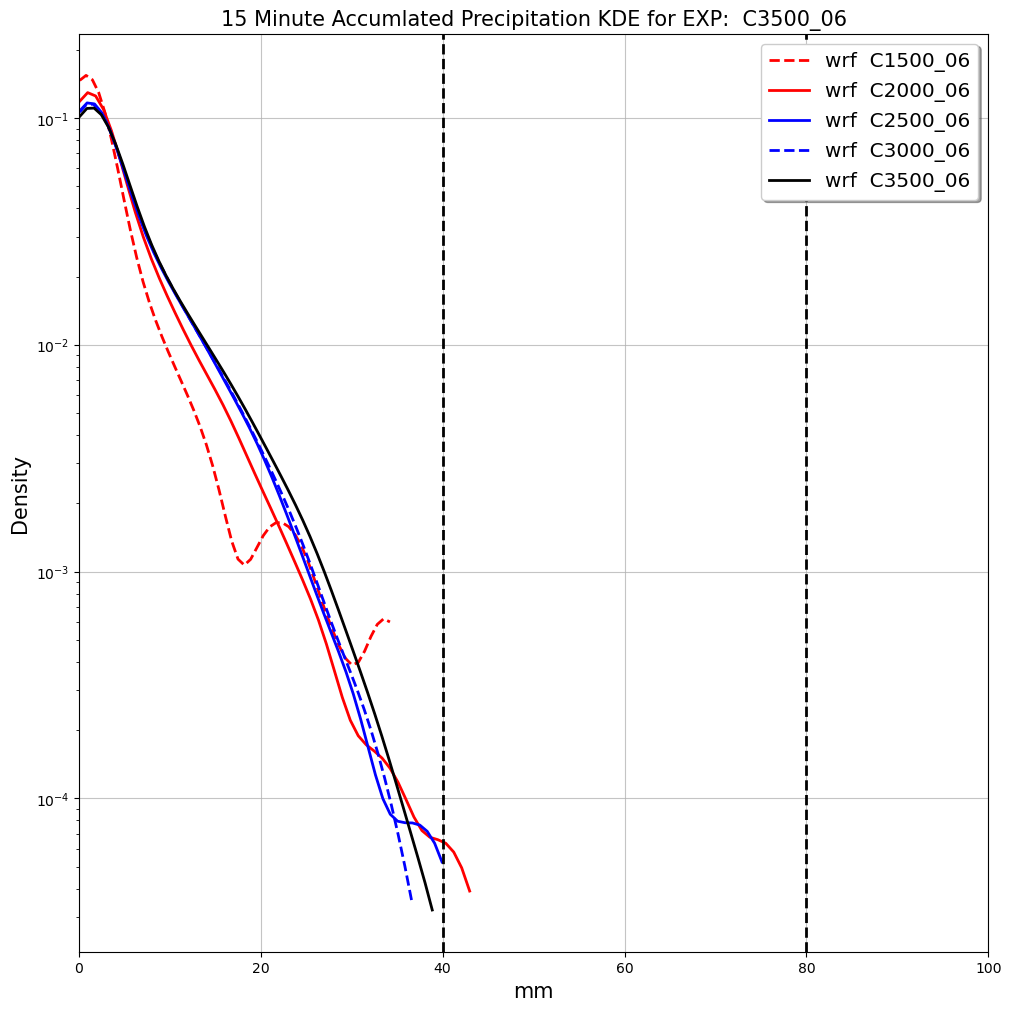

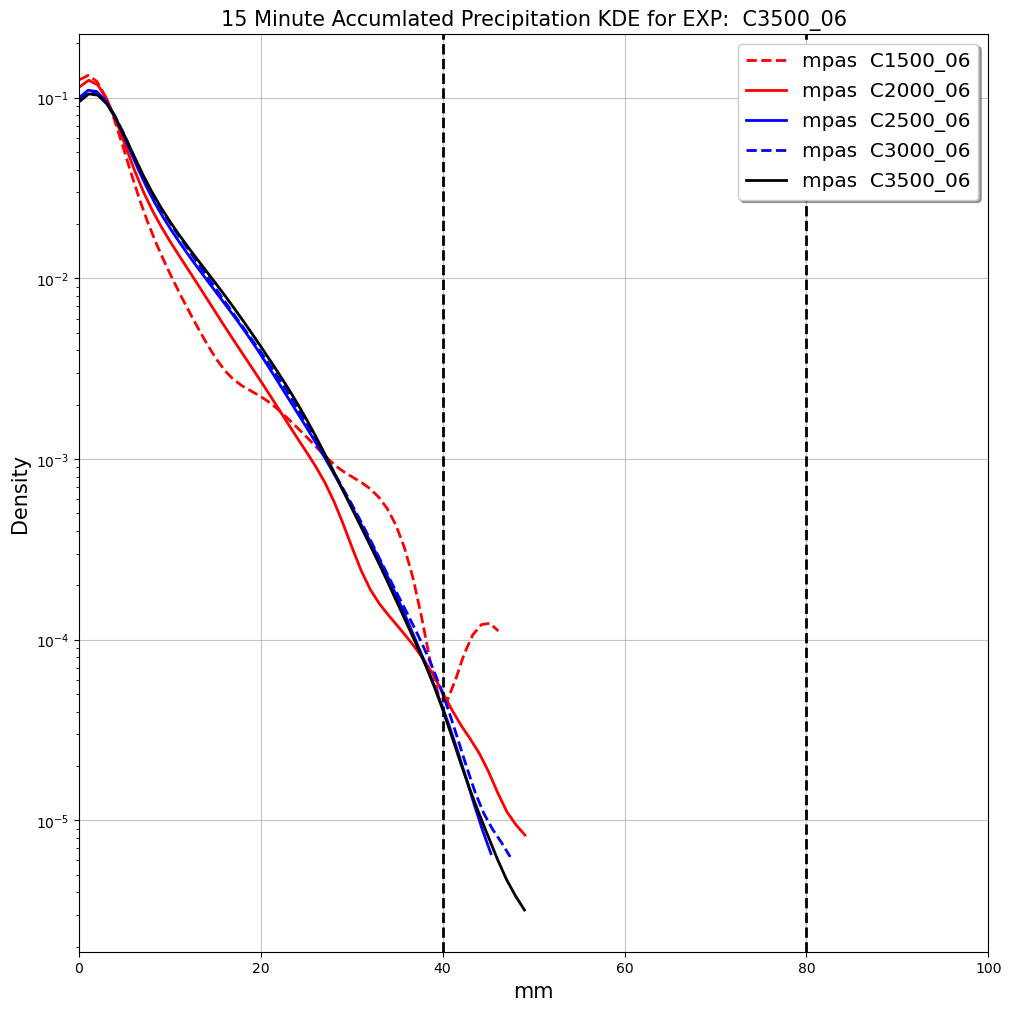

In [21]:
precip_kde2(models, ['solo',], ['C1500_06','C2000_06', 'C2500_06', 'C3000_06', 'C3500_06'], all_times=False)
precip_kde2(models, ['cm1',], ['C1500_06','C2000_06', 'C2500_06', 'C3000_06', 'C3500_06'], all_times=False)
precip_kde2(models, ['wrf',], ['C1500_06','C2000_06', 'C2500_06', 'C3000_06', 'C3500_06'], all_times=False)
precip_kde2(models, ['mpas',], ['C1500_06','C2000_06', 'C2500_06', 'C3000_06', 'C3500_06'], all_times=False)

In [10]:
def precip_bar(models, labels, time=-1, mean=False, log=False):
    
    barWidth = 0.15
    
    fig, ax = plt.subplots(2,1, constrained_layout=True,figsize=(12,8))
    
    xbar1 = np.arange(len(labels)) - barWidth
    xbar2 = [x + barWidth for x in xbar1]
    xbar3 = [x + barWidth for x in xbar2]
    xbar4 = [x + barWidth for x in xbar3]
  
    capes  = labels
    
# create precip data
        
    for key in models.keys():
        
        precip = []
        
        if key == 'solo':
            xloc = xbar1
            color = 'r'
            if time != -1:
                time = time - 1
        if key == 'cm1':
            xloc = xbar2
            color = 'b'
            
        if key == 'wrf':
            xloc = xbar3
            color = 'k'

        if key == 'mpas':
            xloc = xbar4
            color = 'g'

        for label in labels:
                        
            if mean == False:
                if log == False:
                    precip.append(models[key][label]['accum_prec'][time].sum())
                else:
                    precip.append(np.log(models[key][label]['accum_prec'][time].sum()))
            else:
                precip.append(models[key][label]['accum_prec'][time].mean())
                
        ax[0].bar(xloc, precip, color =color, width = barWidth)
        ax[0].set_xticks([r + barWidth for r in range(len(labels))], labels)
        ax[0].set_xlabel('CAPE',fontsize=15)
        if log:
            ax[0].set_ylabel('Log of Accum Precipitation (mm)',fontsize=15)
        else:
            ax[0].set_ylabel('Accum Precipitation (mm)',fontsize=15)
        
        ax[1].plot(xloc, precip, color=color)
        ax[1].set_xticks([r + barWidth for r in range(len(labels))], labels)
        ax[1].set_xlabel('CAPE',fontsize=15)
        if log:
            ax[1].set_ylabel('Log of Accum Precipitation (mm)',fontsize=15)
        else:
            ax[1].set_ylabel('Accum Precipitation (mm)',fontsize=15)

        

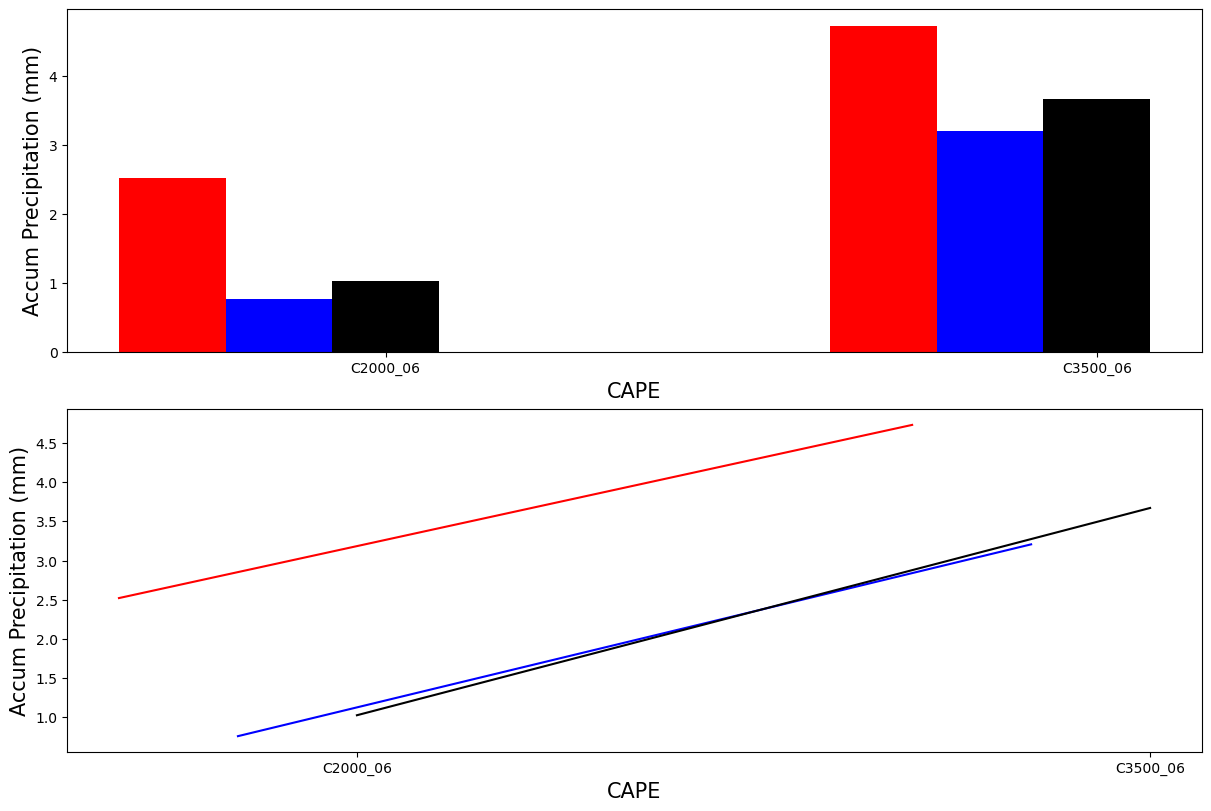

In [11]:
precip_bar(models, ['C2000_06',  'C3500_06'], time=-1, mean=True, log=False)
#precip_bar(models, ['cm1',], ['C1500_06','C2000_06', 'C2500_06', 'C3000_06', 'C3500_06'], time=4)

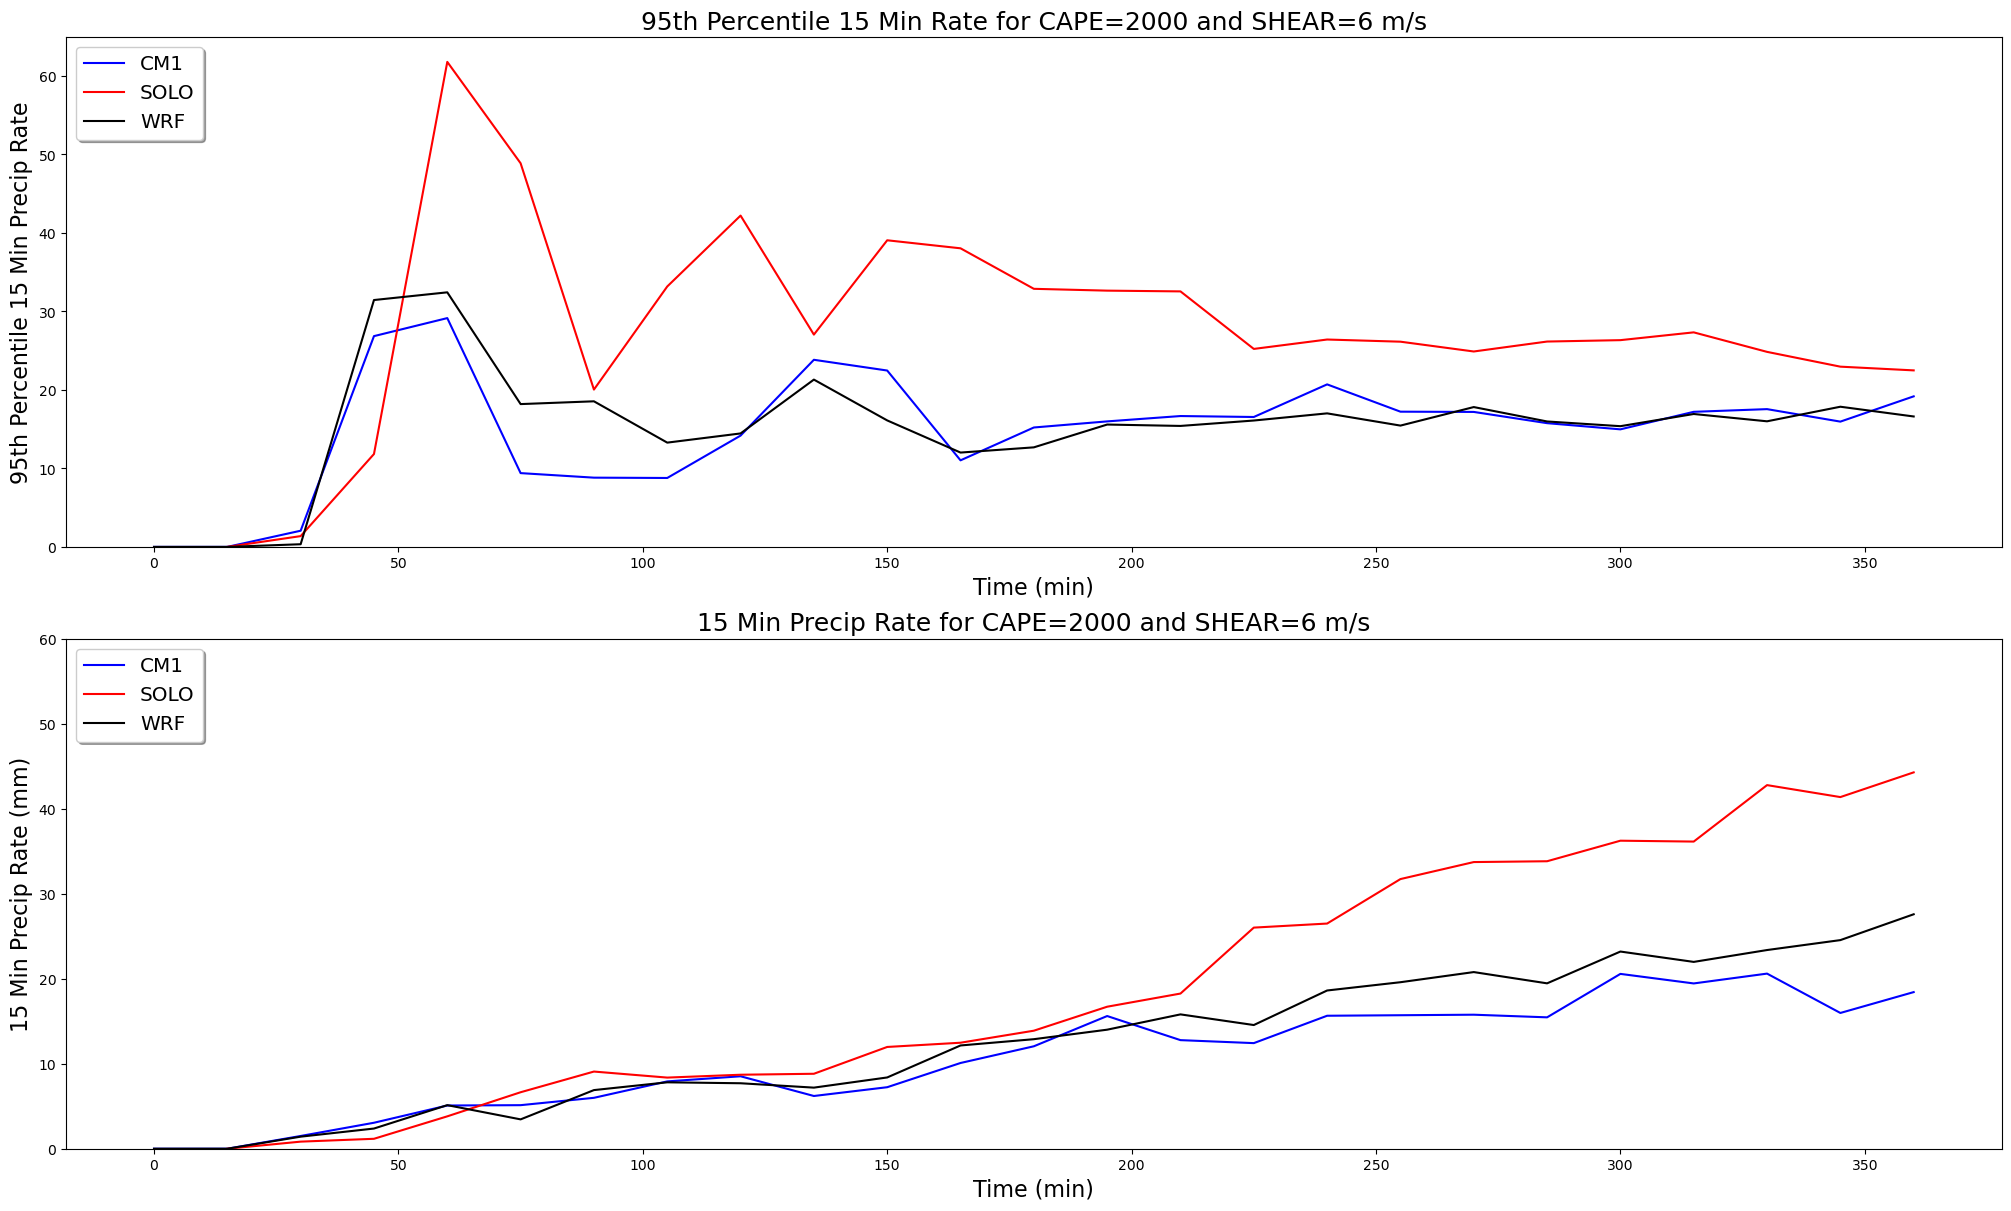

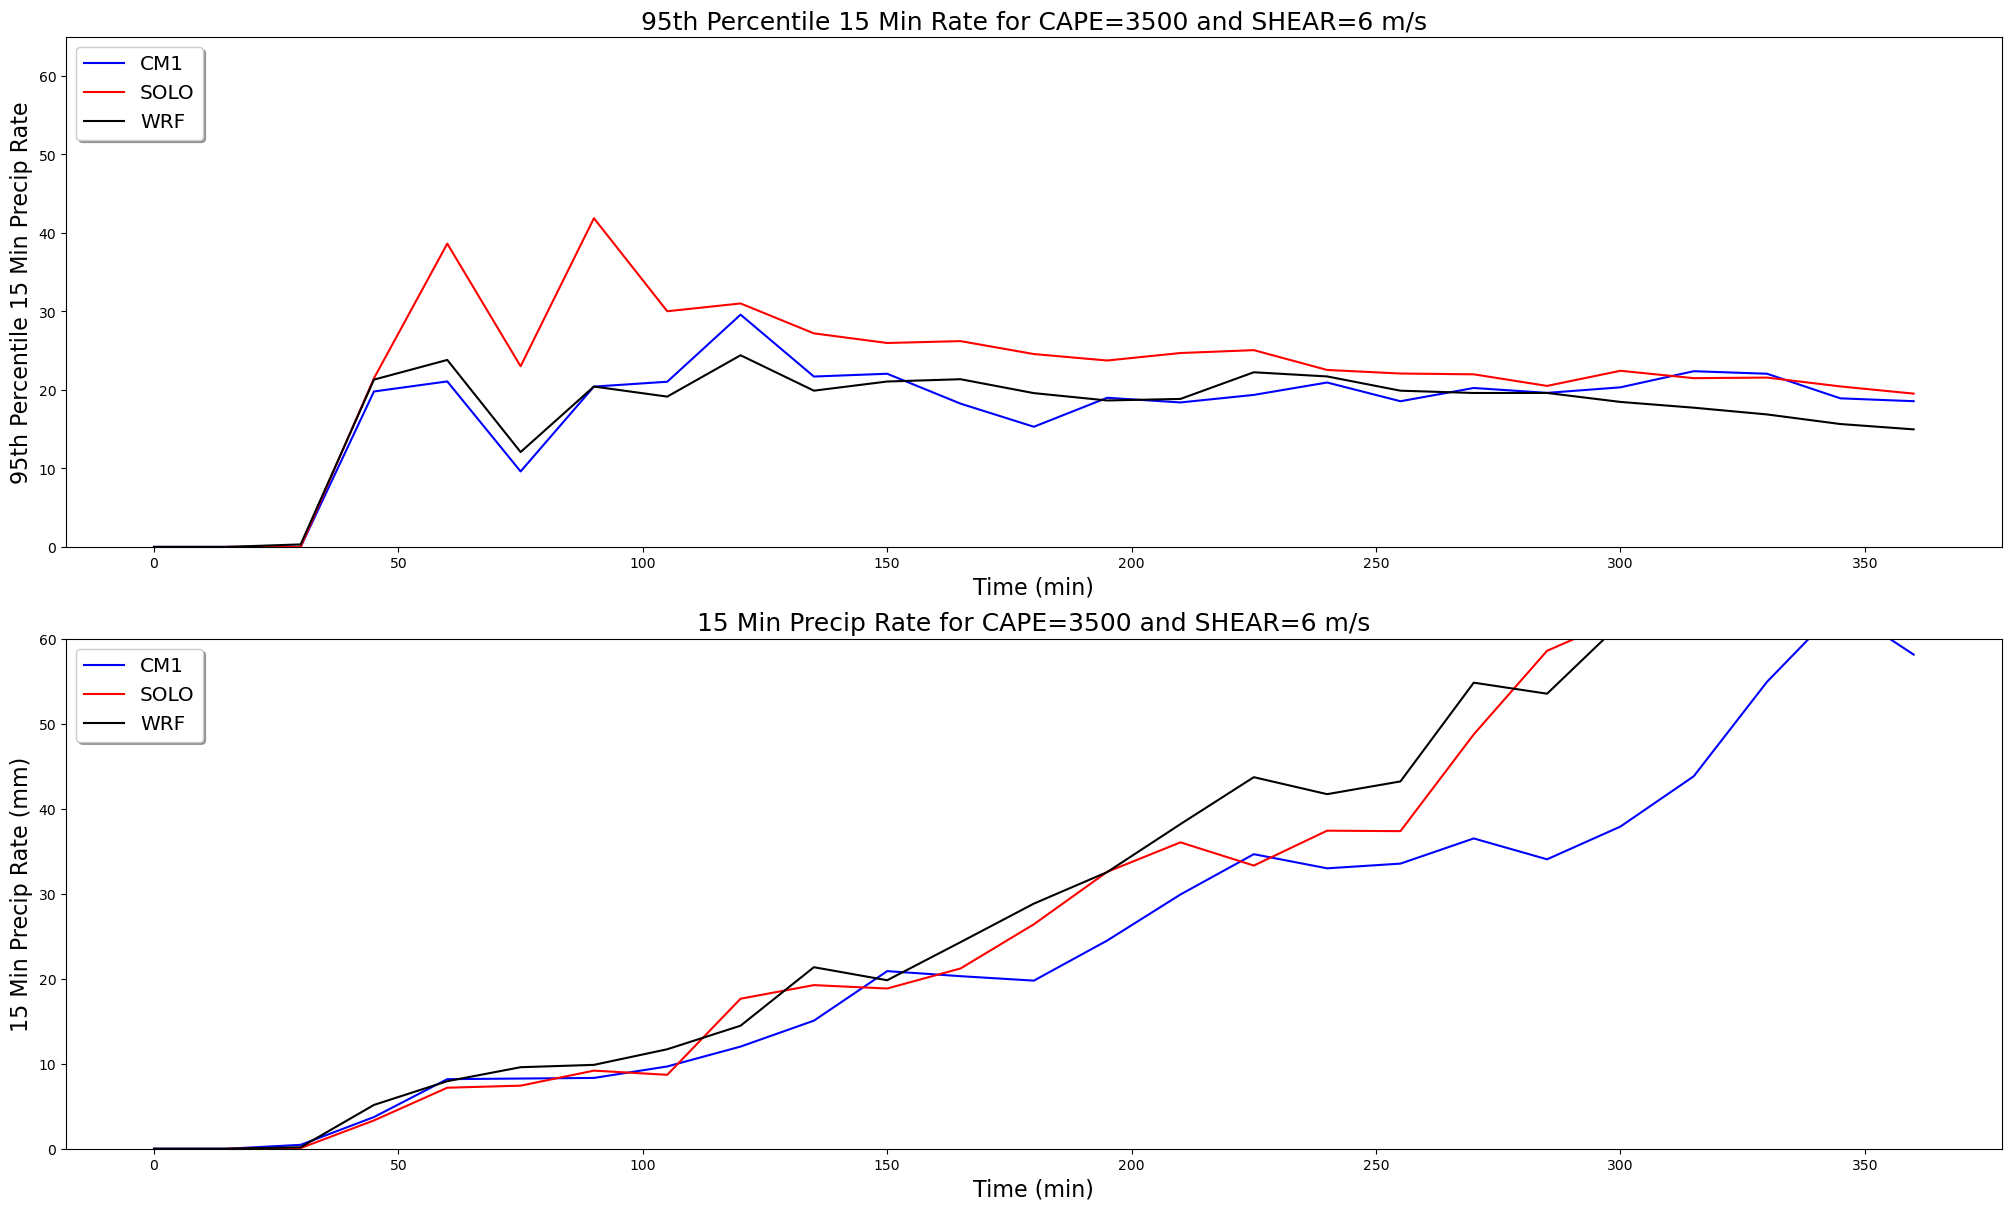

In [14]:
allcape = ("C1500","C2000","C2500","C3000","C3500")
allcape = ("C2000","C3500")
allshear = ("06",)

percent = 0.95

def plot_accum_prec2(models, allcape, allshear, all_times=False):
    
    x = np.arange(5)

    if all_times:
        plim = [ [3.0e5, 5.0e5], [4.0e5, 6.5e5] ]
    else:
        plim = [ [60, 60], [60, 60] ]
        qlim = [ [65, 65], [65, 65] ]

    labels = []
    
    for cape in allcape:
        labels.append("%s" % (cape[1:]))
        
    for m, shear in enumerate(allshear):
        
        for n, cape in enumerate(allcape):
            
            label = "%s_%s" % (cape, shear)
            
            fig, ax = plt.subplots(2,1, constrained_layout=True,figsize=(20,12))

            for key in models.keys():
                
                if all_times:
                    precip = models[key][label]['accum_prec']
                else:
                    inv       = models[key][label]['accum_prec'][::-1]
                    ppp       = np.zeros_like(inv)
                    precip    = np.ma.zeros_like(inv)
                    ppp[1:,:] = (inv[0:-1] - inv[1:])[::-1]
                    precip    = np.ma.masked_greater(ppp, 1.0e-1)
                
                    precip_percent = np.zeros((ppp.shape[0],))
                    
                    for k in np.arange(ppp.shape[0]):
                        ptime   = ppp[k].reshape(precip.shape[1]*precip.shape[2])
                        pthresh = ptime[ptime > 1.0e-01]
                        
                        psort   = np.sort(pthresh)
                        idx     = np.int(percent * psort.shape[0])
                        if idx > 0:
                            precip_percent[k] = np.mean(psort[idx:])
                        else:
                            precip_percent[k] = 0.0
                                            
                if key == 'solo':
                    time = 15. + 15*np.arange(models[key][label]['accum_prec'].shape[0])
                    ax[1].plot(time, precip.sum(axis=(1,2)), color='r', linestyle='-', label='SOLO')
                    if not all_times:
                        ax[0].plot(time, precip_percent, color='r', linestyle='-', label='SOLO')
                    
                if key == 'solohdd02':
                    time = 15. + 15*np.arange(models[key][label]['accum_prec'].shape[0])
                    ax[1].plot(time, precip.sum(axis=(1,2)), color='r', linestyle=':', label='SOLO-HDD')
                    if not all_times:
                        ax[0].plot(time, precip_percent, color='r', linestyle=':', label='SOLO-HDD')

                if key == 'cm1':
                    time = 15*np.arange(models[key][label]['accum_prec'].shape[0])
                    ax[1].plot(time, precip.sum(axis=(1,2)), color='b', linestyle='-', label='CM1')
                    if not all_times:
                        ax[0].plot(time, precip_percent, color='b', linestyle='-', label='CM1')
            
                if key == 'wrf':
                    time = 15*np.arange(models[key][label]['accum_prec'].shape[0])
                    ax[1].plot(time, precip.sum(axis=(1,2)), color='k', linestyle='-', label='WRF')
                    if not all_times:
                        ax[0].plot(time, precip_percent, color='k', linestyle='-', label='WRF')
                        
                if key == 'mpas':
                    time = 15*np.arange(models[key][label]['accum_prec'].shape[0])
                    ax[1].plot(time, precip.sum(axis=(1,2)), color='g', linestyle='-', label='MPAS')
                    if not all_times:
                        ax[0].plot(time, precip_percent, color='g', linestyle='-', label='MPAS')
                        
            ax[0].set_ylabel('95th Percentile 15 Min Precip Rate', fontsize=16)
            ax[1].set_ylabel('15 Min Precip Rate (mm)', fontsize=16)
            ax[0].set_title('95th Percentile 15 Min Rate for CAPE=%d and SHEAR=%d m/s' % (int(cape[1:]), int(shear)), fontsize=18)
            ax[1].set_title('15 Min Precip Rate for CAPE=%d and SHEAR=%d m/s' % (int(cape[1:]), int(shear)), fontsize=18)
            ax[0].set_ylim(0, qlim[m][n])
            ax[1].set_ylim(0, plim[m][n])
            
            for k in [0,1]:
                ax[k].set_xlabel('Time (min)', fontsize=16)
                
                legend = ax[k].legend(loc='upper left', shadow=True, fontsize='x-large')
            
            plt.savefig("Precipitation_Time_Series_Experiment_%s.png" % (label))
            plt.show()
            
###############################

plot_accum_prec2(models, allcape, allshear, all_times=False)

In [15]:
print(b)

NameError: name 'b' is not defined